In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import sklearn
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, BatchNormalization, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint  
from math import sqrt

Using TensorFlow backend.


In [2]:
# Import car and non car images to train classifiers
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')

car_img = []
notcar_img = []
y = []
X_path = []

for car in cars:
#    image = mpimg.imread(car)
#    car_img.append(image)
    y.append(1)
    X_path.append(car)

for notcar in notcars:
#    image = mpimg.imread(notcar)
#    notcar_img.append(image)
    y.append(0)
    X_path.append(notcar)

X_path, y = sklearn.utils.shuffle(X_path,y)
labels = {0: "Not car", 1: "Car"}

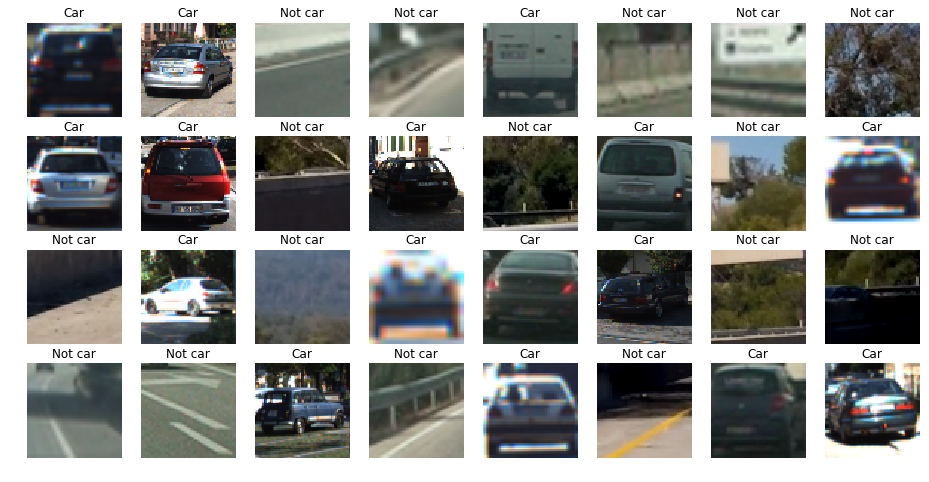

In [3]:
# Visualize the data
fig, axs = plt.subplots(4,8, figsize=(16, 8))
axs = axs.ravel()

for i in range(32):
    image = mpimg.imread(X_path[i])
    axs[i].axis('off')
    axs[i].set_title(labels[y[i]])
    axs[i].imshow(image)

In [4]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img[:, :, np.newaxis]
    img = np.divide(img,np.max(img)/2)
    img[:,:,0] = np.subtract(img[:,:,0],np.mean(img[:,:,0]))
    #img[:,:,1] = np.subtract(img[:,:,0],np.mean(img[:,:,0]))
    #img[:,:,2] = np.subtract(img[:,:,0],np.mean(img[:,:,0]))
    return(img)

In [5]:
def generator(samples, batch_size=512):
    n_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        #sklearn.utils.shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            x_Train = []
            y_Train = []
            for batch_sample in batch_samples:
                x = mpimg.imread(batch_sample[0])
                x = preprocess(x)
                #x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
                #x = np.divide(x,128)
                #x = x[:, :, np.newaxis]
                #x[:,:,0] = np.subtract(x[:,:,0],np.mean(x[:,:,0]))
                #x[:,:,1] = np.subtract(x[:,:,0],np.mean(x[:,:,0]))
                #x[:,:,2] = np.subtract(x[:,:,0],np.mean(x[:,:,0]))
                #x_flip = cv2.flip(x,1)
                #x = cv2.equalizeHist(x)
                #x_flip = x_flip[:, :, np.newaxis]
                y = float(batch_sample[1])
                x_Train.append(x)
                y_Train.append(y)
                #x_Train.append(x_flip)
                #y_Train.append(y)
            x_Train = np.array(x_Train)
            #y_Train = y_Train
            yield sklearn.utils.shuffle(x_Train, y_Train)
            

In [6]:
samples = [(X_path[i], y[i]) for i in range(len(X_path))]
#print(samples[4])
train_samples, valid_samples = train_test_split(samples, test_size=0.20)
train_generator = generator(train_samples, batch_size=512)
valid_generator = generator(valid_samples, batch_size=512)


In [7]:
model = Sequential()
# Center and normalize our data
#model.add(Lambda(lambda x: x, input_shape=(64,64,1), output_shape=(64,64,1)))

model.add(Convolution2D(32,5,5,subsample=(2,2),  input_shape=(64,64,1)))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3,subsample=(2,2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
model.add(Activation('relu'))

#model.add(Convolution2D(128,3,3,subsample=(2,2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
#model.add(Activation('relu'))

#model.add(Convolution2D(64,5,5,subsample=(2,2)))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
#model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(100))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
model.add(Activation('relu'))

model.add(Dense(50))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
model.add(Activation('relu'))

model.add(Dense(10))
#model.add(BatchNormalization())
#model.add(Dropout(0.9))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 30, 30, 32)    832         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 30, 30, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 14, 64)    18496       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 14, 14, 64)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [8]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='weights.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

In [9]:
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=valid_generator, 
                    nb_val_samples=len(valid_samples), nb_epoch=40, callbacks=[checkpointer])


Epoch 1/40
14208/14208 [==============================] - 86s - loss: 0.1625 - acc: 0.7688 - val_loss: 0.0890 - val_acc: 0.8840
Epoch 2/40
14208/14208 [==============================] - 72s - loss: 0.0679 - acc: 0.9124 - val_loss: 0.0526 - val_acc: 0.9305
Epoch 3/40
14208/14208 [==============================] - 74s - loss: 0.0429 - acc: 0.9459 - val_loss: 0.0423 - val_acc: 0.9443
Epoch 4/40
14208/14208 [==============================] - 68s - loss: 0.0325 - acc: 0.9608 - val_loss: 0.0399 - val_acc: 0.9488
Epoch 5/40
14208/14208 [==============================] - 68s - loss: 0.0280 - acc: 0.9671 - val_loss: 0.0376 - val_acc: 0.9479
Epoch 6/40
14208/14208 [==============================] - 67s - loss: 0.0228 - acc: 0.9736 - val_loss: 0.0363 - val_acc: 0.9507
Epoch 7/40
14208/14208 [==============================] - 64s - loss: 0.0175 - acc: 0.9812 - val_loss: 0.0325 - val_acc: 0.9586
Epoch 8/40
14208/14208 [==============================] - 65s - loss: 0.0180 - acc: 0.9792 - val_loss: 0

14208/14208 [==============================] - 65s - loss: 0.0010 - acc: 0.9991 - val_loss: 0.0183 - val_acc: 0.9766
Epoch 32/40
14208/14208 [==============================] - 70s - loss: 0.0010 - acc: 0.9991 - val_loss: 0.0182 - val_acc: 0.9772
Epoch 33/40
14208/14208 [==============================] - 65s - loss: 0.0010 - acc: 0.9991 - val_loss: 0.0186 - val_acc: 0.9761
Epoch 34/40
14208/14208 [==============================] - 65s - loss: 9.8671e-04 - acc: 0.9991 - val_loss: 0.0197 - val_acc: 0.9744
Epoch 35/40
14208/14208 [==============================] - 65s - loss: 9.7854e-04 - acc: 0.9991 - val_loss: 0.0202 - val_acc: 0.9741
Epoch 36/40
14208/14208 [==============================] - 65s - loss: 9.4981e-04 - acc: 0.9991 - val_loss: 0.0210 - val_acc: 0.9735
Epoch 37/40
14208/14208 [==============================] - 65s - loss: 9.0908e-04 - acc: 0.9992 - val_loss: 0.0186 - val_acc: 0.9775
Epoch 38/40
14208/14208 [==============================] - 68s - loss: 8.7927e-04 - acc: 0.99

In [10]:
model.load_weights('weights.hdf5')
model.save('model.h5')

In [11]:
def predict(img_list, model):
    images = []
    for img in img_list: 
        x = preprocess(img)
        images.append(x)
    images = np.array(images)
    predictions = model.predict(images)
    predictions = np.rint(predictions)
        
    return predictions

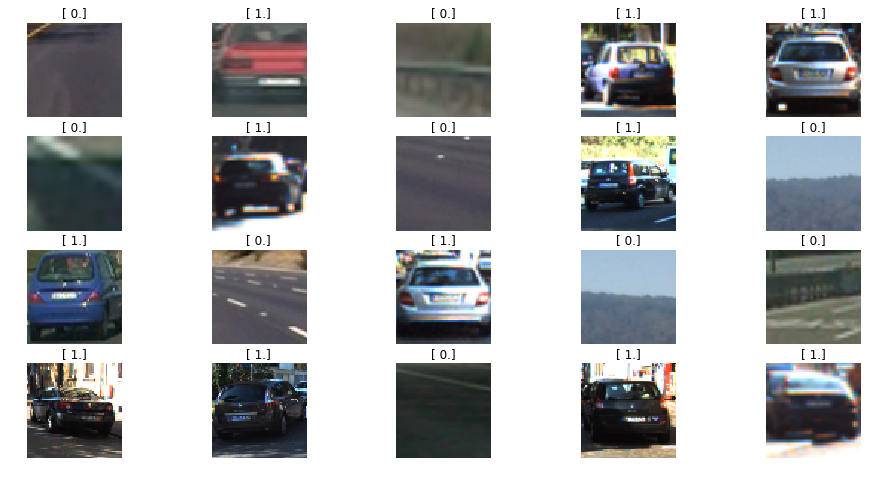

In [12]:
test_images = [mpimg.imread(X_path[np.random.randint(0, len(X_path))]) for i in range(20)]
#test_image1 = mpimg.imread(X_path[np.random.randint(0, len(X_path))])
#test_image1 = preprocess(test_image)
#test_image2 = mpimg.imread(X_path[np.random.randint(0, len(X_path))])
#test_image2 = preprocess(test_image)
#test_images = [test_image1, test_image2] 
#plt.imshow(test_image.squeeze())
#test_label = model.predict([test_images])
#print(test_labels)
#np.shape(test_images)
predicted = predict(test_images, model)

fig, axs = plt.subplots(4,5, figsize=(16, 8))
axs = axs.ravel()

for i in range(20):
    image = test_images[i]
    axs[i].axis('off')
    axs[i].set_title(predicted[i])
    axs[i].imshow(image)

In [13]:
# Define a get windows function to get a sliding set of windows according to a y value
def get_windows(img, y, scale, vis=False):
    imshape = img.shape
    image = cv2.resize(img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    draw_img = np.copy(image)
    x_pixels = imshape[1]/scale
    window_size = 64
    overlap = 4
    n_windows = int(x_pixels/window_size*overlap)
    windows = []
    boxes = []
    x=0
    y=int(y/scale)
    for i in range(n_windows):
        window = np.array(image[y:y+64,x:x+64,:])
        if vis:
            cv2.rectangle(draw_img, (x,y), (x+64,y+64), (0, 0, 255), 3)
        if np.shape(window) == (64, 64, 3):
            windows.append(window)
            boxes.append([(int(x*scale),int(y*scale)),(int((x+64)*scale),int((y+64)*scale))])
        x=x+int(64/overlap)
    if vis:
        plt.imshow(draw_img)
    return(windows, boxes)

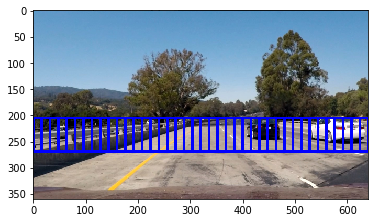

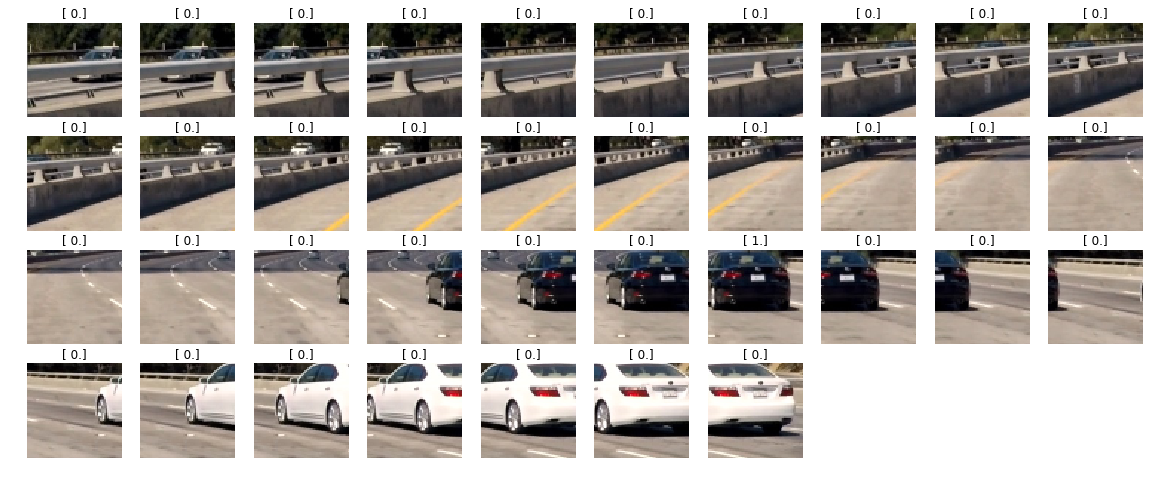

In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')
windows, boxes = get_windows(test_img, 410, 2.0, vis=True)
predictions = predict(windows, model)

fig, axs = plt.subplots(4,10, figsize=(20, 8))
axs = axs.ravel()
#print(boxes)

for i in range(40):
    axs[i].axis('off')
    if i < len(windows):
        axs[i].set_title(predictions[i])
        axs[i].imshow(windows[i])

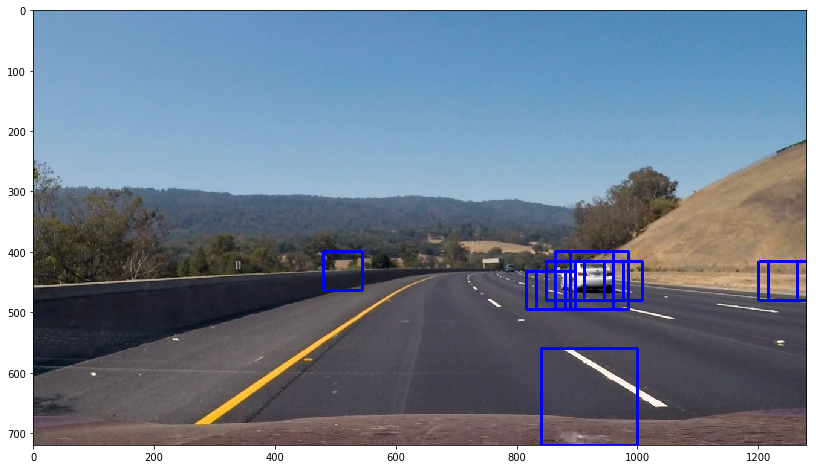

In [75]:
test_img = mpimg.imread('./test_images/test3.jpg')

window_dict = {0: [400,1,1],
              1: [416,1,1],
              2: [432,1,1],
              3: [448,1,1],
              4: [464,1,1],
              5: [480,1,1],
              6: [496,1,1],
              7: [400,1.5,2],
              8: [424,1.5,2],
              9: [448,1.5,2],
              10: [472,1.5,2],
              11: [496,1.5,2],
              12: [520,1.5,2],
              13: [544,1.5,2],
              14: [400,2,2],
              15: [432,2,2],
              16: [464,2,2],
              17: [496,2,2],
              18: [528,2,2],
              19: [400,2.5,1],
              20: [440,2.5,1],
              21: [480,2.5,1],
              22: [520,2.5,1],
              23: [560,2.5,1],
              24: [400,3,1],
              25: [464,3,1],
              26: [528,3,1]}
windows = []
boxes = []
weights = []
window_count = 0
for i in range(len(window_dict)):
    windows_i, boxes_i = get_windows(test_img, window_dict[i][0], window_dict[i][1], vis=False)
    window_count += len(windows_i)
    for window in windows_i:
        windows.append(window)
    for box in boxes_i:
        boxes.append(box)
        weights.append(window_dict[i][2])

window_predictions = predict(windows, model)

hits = []
draw_img = np.copy(test_img)

for i in range(len(window_predictions)):
    if window_predictions[i]:
        cv2.rectangle(draw_img, boxes[i][0], boxes[i][1], (0, 0, 255), 3)
        hits.append([boxes[i], weights[i]])


plt.figure(figsize=(20, 8))
plt.imshow(draw_img)

10


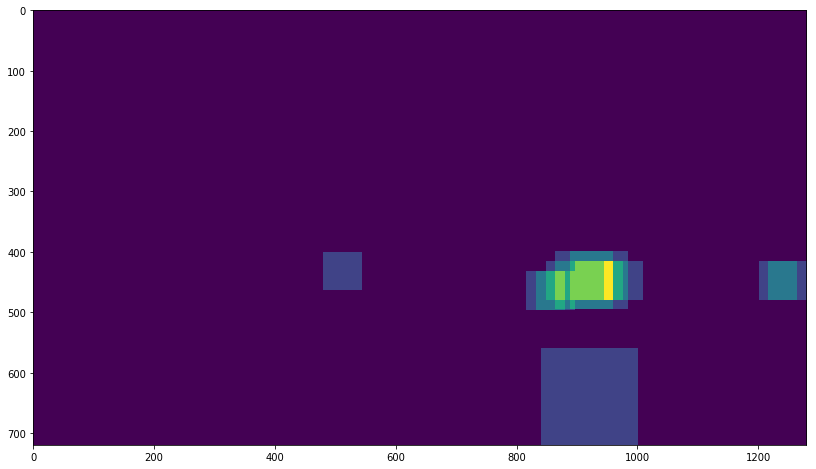

In [76]:
heatmap = np.zeros_like(test_img[:,:,0])
for hit_box in hits:
    heatmap[hit_box[0][0][1]:hit_box[0][1][1], hit_box[0][0][0]:hit_box[0][1][0]] += int(1*sqrt(hit_box[1])*2)
    
plt.figure(figsize=(20, 8))
plt.imshow(heatmap)
print(np.max(heatmap))

1 cars in image


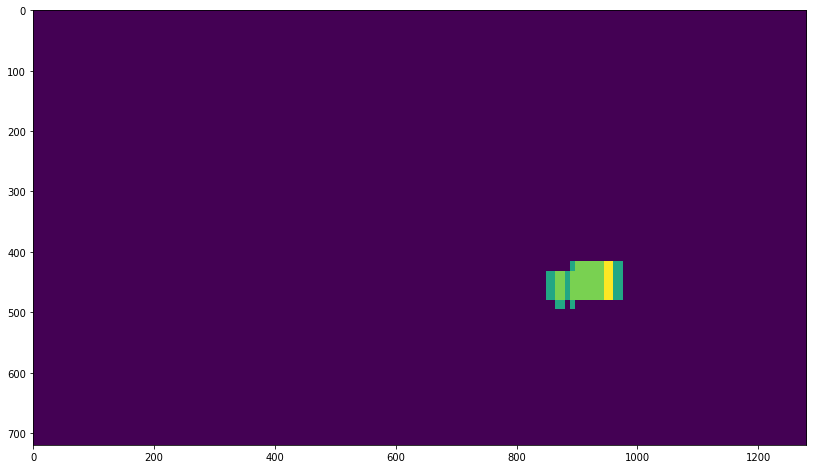

In [31]:
threshold = 5
heatmap[heatmap <= threshold] = 0
plt.figure(figsize=(20, 8))
plt.imshow(heatmap)
labels = label(heatmap)
print(labels[1], 'cars in image')

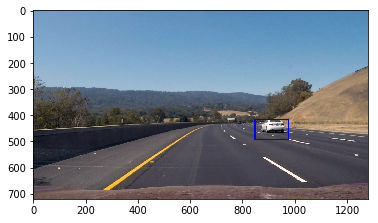

In [32]:
draw_img = np.copy(test_img)

for car in range(1, labels[1]+1):
    nonzero = (labels[0] == car).nonzero()
    # Identify x and y values of those pixels
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Define a bounding box based on min/max x and y
    bbox = [(np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))]
    cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 0, 255), 3)

plt.imshow(draw_img)
    

In [81]:
window_dict = {0: [400,1,1],
              1: [416,1,1],
              2: [432,1,1],
              3: [448,1,1],
              4: [464,1,1],
              5: [480,1,1],
              6: [496,1,1],
              7: [400,1.5,2],
              8: [424,1.5,2],
              9: [448,1.5,2],
              10: [472,1.5,2],
              11: [496,1.5,2],
              12: [520,1.5,2],
              13: [544,1.5,2],
              14: [400,2,2],
              15: [432,2,2],
              16: [464,2,2],
              17: [496,2,2],
              18: [528,2,2],
              19: [400,2.5,1],
              20: [440,2.5,1],
              21: [480,2.5,1],
              22: [520,2.5,1],
              23: [560,2.5,1],
              24: [400,3,1],
              25: [464,3,1],
              26: [528,3,1]}

def process_image(img):
    
    global model
    global window_dict
    
    windows = []
    boxes = []
    weights = []
    window_count = 0
    
    for i in range(len(window_dict)):
        windows_i, boxes_i = get_windows(img, window_dict[i][0], window_dict[i][1], vis=False)
        window_count += len(windows_i)
        for window in windows_i:
            windows.append(window)
        for box in boxes_i:
            boxes.append(box)
            weights.append(window_dict[i][2])

    window_predictions = predict(windows, model)

    hits = []

    for i in range(len(window_predictions)):
        if window_predictions[i]:
            hits.append([boxes[i], weights[i]])
            
    heatmap = np.zeros_like(img[:,:,0])
    
    for hit_box in hits:
        heatmap[hit_box[0][0][1]:hit_box[0][1][1], hit_box[0][0][0]:hit_box[0][1][0]] += hit_box[1]

    threshold = 5
    heatmap[heatmap <= threshold] = 0
    labels = label(heatmap)
    
    draw_img = np.copy(img)
    
    for car in range(1, labels[1]+1):
        nonzero = (labels[0] == car).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = [(np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy))]
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 0, 255), 3)

    return(draw_img)
    

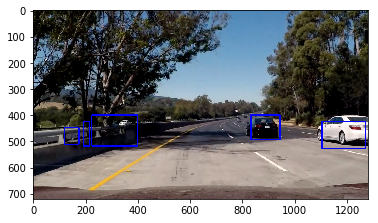

In [86]:
test_img = mpimg.imread('./test_images/test5.jpg')
draw_img = process_image(test_img)
plt.imshow(draw_img)

In [87]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [88]:
video_output  = "output_videos\project_video.mp4"
clip = VideoFileClip('.\project_video.mp4')
processed_clip = clip.fl_image(process_image)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos\project_video.mp4
[MoviePy] Writing video output_videos\project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [25:06<00:01,  1.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos\project_video.mp4 

Wall time: 25min 7s
